In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import random
import os
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_data_path = '/content/drive/MyDrive/MRI/Training'
test_data_path = '/content/drive/MyDrive/MRI/Testing'

In [23]:
# Getting Training and Testing Data

training_data = tf.keras.preprocessing.image_dataset_from_directory(train_data_path,seed=123,
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256))
testing_data = tf.keras.preprocessing.image_dataset_from_directory(test_data_path,seed=123,
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256))

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [24]:
training_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
for image_batch, labels_batch in training_data:
  print(image_batch.shape)
  print(labels_batch)
  break

(32, 256, 256, 3)
tf.Tensor([3 3 1 1 1 0 0 3 1 3 2 1 3 2 2 1 1 2 1 0 2 2 3 3 2 3 1 3 1 1 0 3], shape=(32,), dtype=int32)


In [26]:
class_names = training_data.class_names


In [27]:
testing_data.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

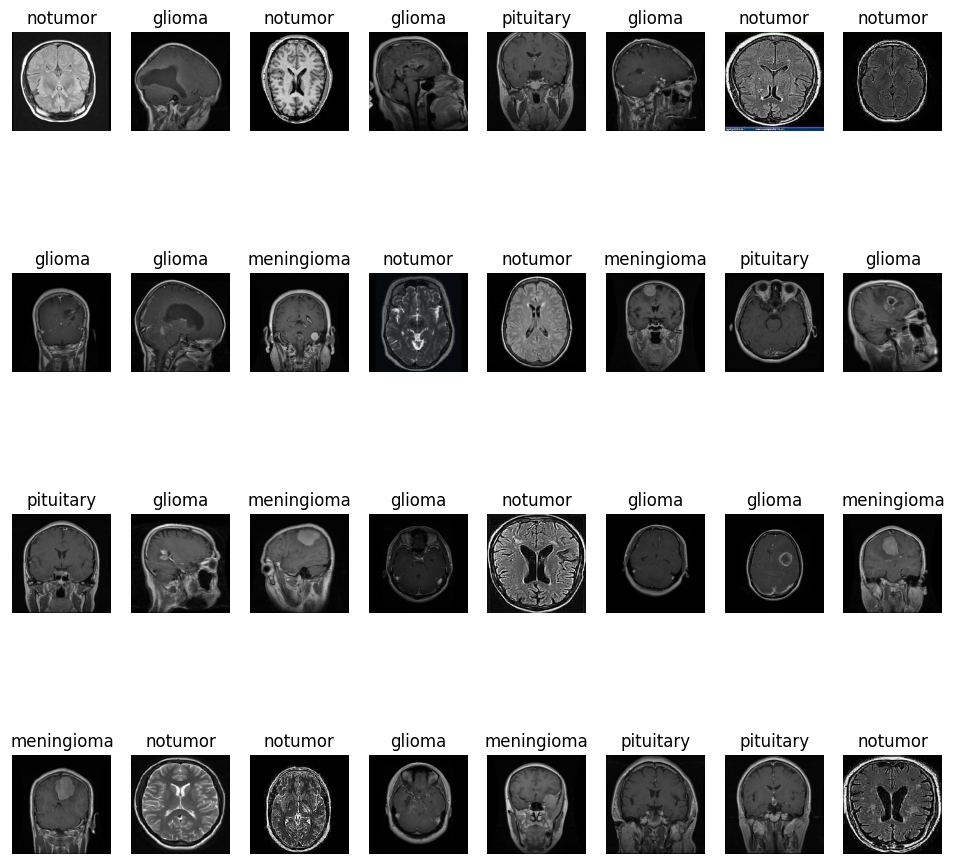

In [32]:
plt.figure(figsize=(12,12))
for img, label in training_data.take(1):
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(img[i])
        plt.title(class_names[label[i]])
        plt.axis('off')

In [33]:
len(training_data.take(1))

1

In [34]:
Autotune = tf.data.AUTOTUNE

training_data = training_data.cache().prefetch(buffer_size=Autotune)
testing_data = testing_data.cache().prefetch(buffer_size=Autotune)

In [41]:
img, label
training_data.take(1)
for img, label in training_data.take(1):
    print(img.shape)
    print(label)

(32, 256, 256, 3)
tf.Tensor([0 0 0 1 3 0 3 2 2 1 2 2 0 2 2 0 3 1 1 3 3 2 3 1 2 2 2 3 2 1 1 2], shape=(32,), dtype=int32)


# Bottle Neck Layer

In [58]:
# Bottle Neck Layer

def bottle_neck_layer(x, filters, strides=1):
  skip_connection = x

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(4*filters, kernel_size=1, strides=strides, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)

  x = tf.keras.layers.Concatenate()([x,skip_connection])

  return x

# Transition Layer

In [67]:
def transition_layer(x):

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(tf.keras.backend.int_shape(x)[-1]//2,kernel_size=1,strides=1,padding='same')(x)
  x = tf.keras.layers.AvgPool2D(2, strides=2, padding='same')(x)

  return x

# Dense Layer

In [68]:
def dense_block(x,repetition=1,growth_rate=32):
    for _ in range(repetition):
        x = bottle_neck_layer(x,growth_rate)
    return x

# DenseNet-B121

In [69]:
def densenetb121(input_shape, num_classes, growth_rate=32):
  #Input layer of the model, shape resembles the input shape

  inputs = tf.keras.Input(shape=input_shape)

  x = tf.keras.layers.BatchNormalization()(inputs)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)


  x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

  #First Dense Block

  x = dense_block(x, 6, growth_rate)
  x = transition_layer(x)

  #Second Dense Block

  x = dense_block(x,12,growth_rate)
  x = transition_layer(x)

  #Third Dense Block

  x = dense_block(x, 24, growth_rate)
  x = transition_layer(x)

  #Last Dense Block
  x = dense_block(x, 16, growth_rate)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [70]:
model = densenetb121(input_shape=(256,256,3), num_classes=len(class_names))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 256, 256, 3)    │             12 │ input_layer_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 256, 256, 3)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 128, 128, 64)   │          9,472 │ re_lu_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 64, 64, 64)     │            256 │ max_pooling2d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ re_lu_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 64, 64, 128)    │            512 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 32)     │         36,896 │ re_lu_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 64, 64, 96)     │              0 │ conv2d_32[0][0],       │
│ (Concatenate)             │                        │                │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 64, 64, 96)     │            384 │ concatenate_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 64, 64, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 128)    │         12,416 │ re_lu_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 64, 64, 128)    │            512 │ conv2d_33[0][0]        │
│ (BatchNormalization) 

 Total params: 7,047,504 (26.88 MB)

 Trainable params: 6,966,026 (26.57 MB)

 Non-trainable params: 81,478 (318.27 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.231423 to fit



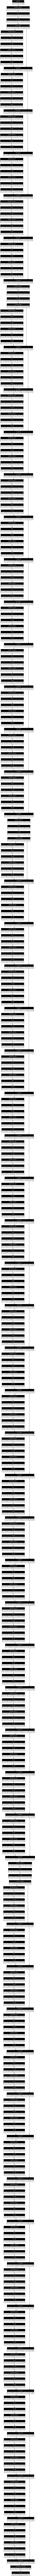

In [71]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [73]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.metrics.SparseCategoricalAccuracy(name='accuracy')]

)

In [75]:
history = model.fit(
    training_data,
    validation_data=testing_data,
    epochs=4,
    batch_size =32
)

Epoch 1/4
179/179 ━━━━━━━━━━━━━━━━━━━━ 953s 5s/step - accuracy: 0.6902 - loss: 0.8512 - val_accuracy: 0.2967 - val_loss: 1.6619
Epoch 2/4
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 378ms/step - accuracy: 0.7640 - loss: 0.6401 - val_accuracy: 0.6552 - val_loss: 0.8325
Epoch 3/4
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 371ms/step - accuracy: 0.8218 - loss: 0.4807 - val_accuracy: 0.5095 - val_loss: 1.6230
Epoch 4/4
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 377ms/step - accuracy: 0.8588 - loss: 0.3830 - val_accuracy: 0.7925 - val_loss: 0.5473


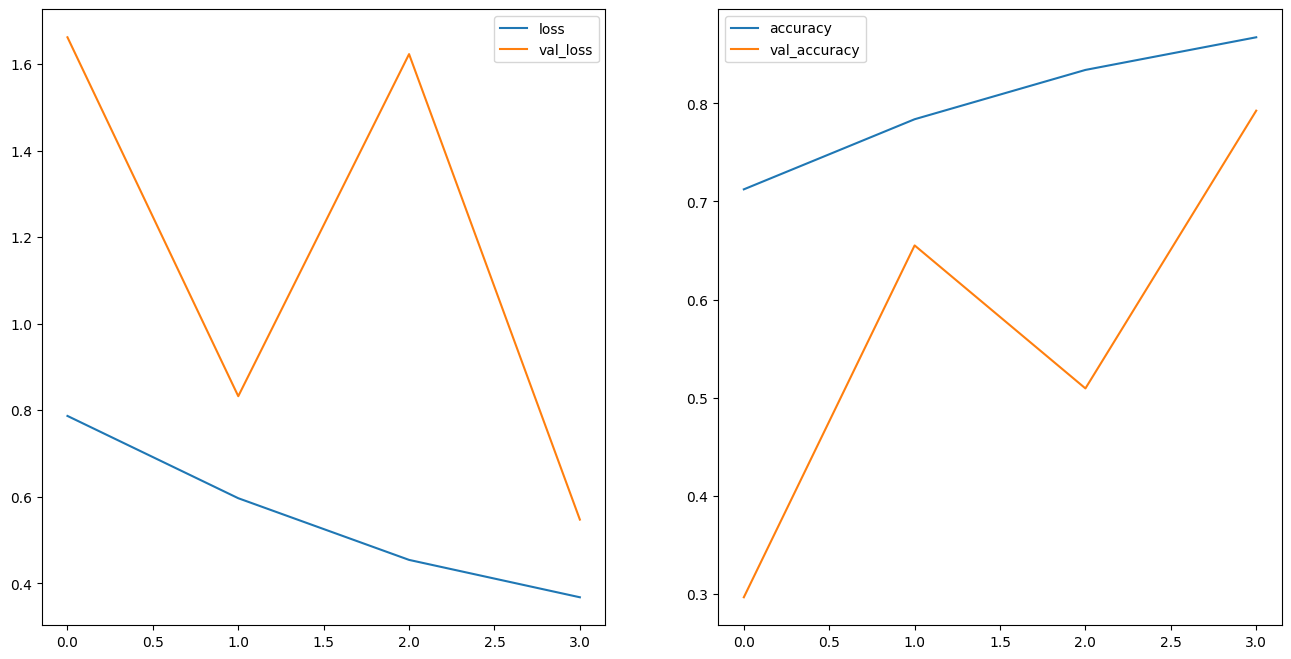

In [77]:
import pandas as pd
plt.figure(figsize=(16,8))

plt.subplot(121)
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot(ax=plt.gca())


plt.subplot(122)
hist_df.loc[:,['accuracy','val_accuracy']].plot(ax=plt.gca())

plt.show()


In [79]:
loss,accuracy = model.evaluate(testing_data)

print('Loss:',loss)
print('Accuracy:',accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7803 - loss: 0.5631
Loss: 0.5473368763923645
Accuracy: 0.7925248146057129
